In [37]:
# Copyright (c) Facebook, Inc. and its affiliates.
import contextlib
import io
import logging
import os
from collections import defaultdict
from dataclasses import dataclass
from typing import Any, Dict, Iterable, List, Optional
from fvcore.common.timer import Timer

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.file_io import PathManager

from densepose.data.utils import maybe_prepend_base_path
from pathlib import Path
from detectron2.utils.logger import setup_logger

setup_logger()

<Logger detectron2 (DEBUG)>

In [50]:
DENSEPOSE_MASK_KEY = "dp_masks"
DENSEPOSE_IUV_KEYS_WITHOUT_MASK = ["dp_x", "dp_y", "dp_I", "dp_U", "dp_V"]
DENSEPOSE_CSE_KEYS_WITHOUT_MASK = ["dp_x", "dp_y", "dp_vertex", "ref_model"]
DENSEPOSE_ALL_POSSIBLE_KEYS = set(DENSEPOSE_IUV_KEYS_WITHOUT_MASK + DENSEPOSE_CSE_KEYS_WITHOUT_MASK + [DENSEPOSE_MASK_KEY])
DENSEPOSE_METADATA_URL_PREFIX = "https://dl.fbaipublicfiles.com/densepose/data/"


@dataclass
class CocoDatasetInfo:
    name: str
    images_root: str
    annotations_fpath: str


DATASETS = [
    CocoDatasetInfo(
        name="densepose_coco_2014_train",
        images_root="coco/train2014",
        annotations_fpath="coco/annotations/densepose_train2014.json",
    ),
    CocoDatasetInfo(
        name="densepose_coco_2014_minival",
        images_root="coco/val2014",
        annotations_fpath="coco/annotations/densepose_minival2014.json",
    ),
    CocoDatasetInfo(
        name="densepose_coco_2014_minival_100",
        images_root="coco/val2014",
        annotations_fpath="coco/annotations/densepose_minival2014_100.json",
    ),
    CocoDatasetInfo(
        name="densepose_coco_2014_valminusminival",
        images_root="coco/val2014",
        annotations_fpath="coco/annotations/densepose_valminusminival2014.json",
    ),
    CocoDatasetInfo(
        name="densepose_coco_2014_train_cse",
        images_root="coco/train2014",
        annotations_fpath="coco_cse/densepose_train2014_cse.json",
    ),
    CocoDatasetInfo(
        name="densepose_coco_2014_minival_cse",
        images_root="coco/val2014",
        annotations_fpath="coco_cse/densepose_minival2014_cse.json",
    ),
    CocoDatasetInfo(
        name="densepose_coco_2014_minival_100_cse",
        images_root="coco/val2014",
        annotations_fpath="coco_cse/densepose_minival2014_100_cse.json",
    ),
    CocoDatasetInfo(
        name="densepose_coco_2014_valminusminival_cse",
        images_root="coco/val2014",
        annotations_fpath="coco_cse/densepose_valminusminival2014_cse.json",
    ),
    CocoDatasetInfo(
        name="densepose_chimps",
        images_root="densepose_chimps/images",
        annotations_fpath="densepose_chimps/densepose_chimps_densepose.json",
    ),
    CocoDatasetInfo(
        name="densepose_chimps_cse_train",
        images_root="densepose_chimps/images",
        annotations_fpath="densepose_chimps/densepose_chimps_cse_train.json",
    ),
    CocoDatasetInfo(
        name="densepose_chimps_cse_val",
        images_root="densepose_chimps/images",
        annotations_fpath="densepose_chimps/densepose_chimps_cse_val.json",
    ),
    CocoDatasetInfo(
        name="posetrack2017_train",
        images_root="posetrack2017/posetrack_data_2017",
        annotations_fpath="posetrack2017/densepose_posetrack_train2017.json",
    ),
    CocoDatasetInfo(
        name="posetrack2017_val",
        images_root="posetrack2017/posetrack_data_2017",
        annotations_fpath="posetrack2017/densepose_posetrack_val2017.json",
    ),
    CocoDatasetInfo(
        name="lvis_v05_train",
        images_root="coco/train2017",
        annotations_fpath="lvis/lvis_v0.5_plus_dp_train.json",
    ),
    CocoDatasetInfo(
        name="lvis_v05_val",
        images_root="coco/val2017",
        annotations_fpath="lvis/lvis_v0.5_plus_dp_val.json",
    ),
]


BASE_DATASETS = [
    CocoDatasetInfo(
        name="base_coco_2017_train",
        images_root="coco/train2017",
        annotations_fpath="coco/annotations/instances_train2017.json",
    ),
    CocoDatasetInfo(
        name="base_coco_2017_val",
        images_root="coco/val2017",
        annotations_fpath="coco/annotations/instances_val2017.json",
    ),
    CocoDatasetInfo(
        name="base_coco_2017_val_100",
        images_root="coco/val2017",
        annotations_fpath="coco/annotations/instances_val2017_100.json",
    ),
]


def get_metadata(base_path: Optional[str]) -> Dict[str, Any]:
    """
    Returns metadata associated with COCO DensePose datasets

    Args:
    base_path: Optional[str]
        Base path used to load metadata from

    Returns:
    Dict[str, Any]
        Metadata in the form of a dictionary
    """
    meta = {
        "densepose_transform_src": maybe_prepend_base_path(base_path, "UV_symmetry_transforms.mat"),
        "densepose_smpl_subdiv": maybe_prepend_base_path(base_path, "SMPL_subdiv.mat"),
        "densepose_smpl_subdiv_transform": maybe_prepend_base_path(
            base_path,
            "SMPL_SUBDIV_TRANSFORM.mat",
        ),
    }
    return meta


def _load_coco_annotations(json_file: str):
    """
    Load COCO annotations from a JSON file

    Args:
        json_file: str
            Path to the file to load annotations from
    Returns:
        Instance of `pycocotools.coco.COCO` that provides access to annotations
        data
    """
    from pycocotools.coco import COCO

    logger = logging.getLogger(__name__)
    timer = Timer()
    with contextlib.redirect_stdout(io.StringIO()):
        coco_api = COCO(json_file)
    if timer.seconds() > 1:
        logger.info("Loading {} takes {:.2f} seconds.".format(json_file, timer.seconds()))
    return coco_api


def _add_categories_metadata(dataset_name: str, categories: List[Dict[str, Any]]):
    meta = MetadataCatalog.get(dataset_name)
    meta.categories = {c["id"]: c["name"] for c in categories}
    logger = logging.getLogger(__name__)
    logger.info("Dataset {} categories: {}".format(dataset_name, meta.categories))


def _verify_annotations_have_unique_ids(json_file: str, anns: List[List[Dict[str, Any]]]):
    if "minival" in json_file:
        # Skip validation on COCO2014 valminusminival and minival annotations
        # The ratio of buggy annotations there is tiny and does not affect accuracy
        # Therefore we explicitly white-list them
        return
    ann_ids = [ann["id"] for anns_per_image in anns for ann in anns_per_image]
    assert len(set(ann_ids)) == len(ann_ids), "Annotation ids in '{}' are not unique!".format(
        json_file
    )


def _maybe_add_bbox(obj: Dict[str, Any], ann_dict: Dict[str, Any]):
    if "bbox" not in ann_dict:
        return
    obj["bbox"] = ann_dict["bbox"]
    obj["bbox_mode"] = BoxMode.XYWH_ABS


def _maybe_add_segm(obj: Dict[str, Any], ann_dict: Dict[str, Any]):
    if "segmentation" not in ann_dict:
        return
    segm = ann_dict["segmentation"]
    if not isinstance(segm, dict):
        # filter out invalid polygons (< 3 points)
        segm = [poly for poly in segm if len(poly) % 2 == 0 and len(poly) >= 6]
        if len(segm) == 0:
            return
    obj["segmentation"] = segm


def _maybe_add_keypoints(obj: Dict[str, Any], ann_dict: Dict[str, Any]):
    if "keypoints" not in ann_dict:
        return
    keypts = ann_dict["keypoints"]  # list[int]
    for idx, v in enumerate(keypts):
        if idx % 3 != 2:
            # COCO's segmentation coordinates are floating points in [0, H or W],
            # but keypoint coordinates are integers in [0, H-1 or W-1]
            # Therefore we assume the coordinates are "pixel indices" and
            # add 0.5 to convert to floating point coordinates.
            keypts[idx] = v + 0.5
    obj["keypoints"] = keypts


def _maybe_add_densepose(obj: Dict[str, Any], ann_dict: Dict[str, Any]):
    for key in DENSEPOSE_ALL_POSSIBLE_KEYS:
        if key in ann_dict:
            obj[key] = ann_dict[key]


def _combine_images_with_annotations(
    dataset_name: str,
    image_root: str,
    human_parsing_image_root: str,
    human_parsing_image_ext: str,
    img_datas: Iterable[Dict[str, Any]],
    ann_datas: Iterable[Iterable[Dict[str, Any]]],
):

    ann_keys = ["iscrowd", "category_id"]
    dataset_dicts = []
    contains_video_frame_info = False

    for img_dict, ann_dicts in zip(img_datas, ann_datas):
        record = {}
        record["file_name"] = os.path.join(image_root, img_dict["file_name"])
        
        sem_seg_file_name = Path(os.path.basename(record["file_name"]))
        sem_seg_file_name = str(sem_seg_file_name).replace(sem_seg_file_name.suffix, human_parsing_image_ext)
        record["sem_seg_file_name"] = os.path.join(human_parsing_image_root, sem_seg_file_name)
        
        record["height"] = img_dict["height"]
        record["width"] = img_dict["width"]
        record["image_id"] = img_dict["id"]
        record["dataset"] = dataset_name
        
        if "frame_id" in img_dict:
            record["frame_id"] = img_dict["frame_id"]
            record["video_id"] = img_dict.get("vid_id", None)
            contains_video_frame_info = True
        
        objs = []
        for ann_dict in ann_dicts:
            assert ann_dict["image_id"] == record["image_id"]
            assert ann_dict.get("ignore", 0) == 0
            obj = {key: ann_dict[key] for key in ann_keys if key in ann_dict}
            _maybe_add_bbox(obj, ann_dict)
            _maybe_add_segm(obj, ann_dict)
            _maybe_add_keypoints(obj, ann_dict)
            _maybe_add_densepose(obj, ann_dict)
            objs.append(obj)
        
        record["annotations"] = objs
        dataset_dicts.append(record)
    
    if contains_video_frame_info:
        create_video_frame_mapping(dataset_name, dataset_dicts)
    return dataset_dicts


def get_contiguous_id_to_category_id_map(metadata):
    cat_id_2_cont_id = metadata.thing_dataset_id_to_contiguous_id
    cont_id_2_cat_id = {}
    for cat_id, cont_id in cat_id_2_cont_id.items():
        if cont_id in cont_id_2_cat_id:
            continue
        cont_id_2_cat_id[cont_id] = cat_id
    return cont_id_2_cat_id


def maybe_filter_categories_cocoapi(dataset_name, coco_api):
    meta = MetadataCatalog.get(dataset_name)
    cont_id_2_cat_id = get_contiguous_id_to_category_id_map(meta)
    cat_id_2_cont_id = meta.thing_dataset_id_to_contiguous_id
    # filter categories
    cats = []
    for cat in coco_api.dataset["categories"]:
        cat_id = cat["id"]
        if cat_id not in cat_id_2_cont_id:
            continue
        cont_id = cat_id_2_cont_id[cat_id]
        if (cont_id in cont_id_2_cat_id) and (cont_id_2_cat_id[cont_id] == cat_id):
            cats.append(cat)
    coco_api.dataset["categories"] = cats
    # filter annotations, if multiple categories are mapped to a single
    # contiguous ID, use only one category ID and map all annotations to that category ID
    anns = []
    for ann in coco_api.dataset["annotations"]:
        cat_id = ann["category_id"]
        if cat_id not in cat_id_2_cont_id:
            continue
        cont_id = cat_id_2_cont_id[cat_id]
        ann["category_id"] = cont_id_2_cat_id[cont_id]
        anns.append(ann)
    coco_api.dataset["annotations"] = anns
    # recreate index
    coco_api.createIndex()


def maybe_filter_and_map_categories_cocoapi(dataset_name, coco_api):
    meta = MetadataCatalog.get(dataset_name)
    category_id_map = meta.thing_dataset_id_to_contiguous_id
    # map categories
    cats = []
    for cat in coco_api.dataset["categories"]:
        cat_id = cat["id"]
        if cat_id not in category_id_map:
            continue
        cat["id"] = category_id_map[cat_id]
        cats.append(cat)
    coco_api.dataset["categories"] = cats
    # map annotation categories
    anns = []
    for ann in coco_api.dataset["annotations"]:
        cat_id = ann["category_id"]
        if cat_id not in category_id_map:
            continue
        ann["category_id"] = category_id_map[cat_id]
        anns.append(ann)
    coco_api.dataset["annotations"] = anns
    # recreate index
    coco_api.createIndex()


def create_video_frame_mapping(dataset_name, dataset_dicts):
    mapping = defaultdict(dict)
    for d in dataset_dicts:
        video_id = d.get("video_id")
        if video_id is None:
            continue
        mapping[video_id].update({d["frame_id"]: d["file_name"]})
    MetadataCatalog.get(dataset_name).set(video_frame_mapping=mapping)


def load_coco_json(
    annotations_json_file: str, 
    image_root: str, 
    dataset_name: str, 
    human_parsing_image_root: str,
    human_parse_image_suffix: str,
):
    """
    Loads a JSON file with annotations in COCO instances format.
    Replaces `detectron2.data.datasets.coco.load_coco_json` to handle metadata
    in a more flexible way. Postpones category mapping to a later stage to be
    able to combine several datasets with different (but coherent) sets of
    categories.

    Args:

    annotations_json_file: str
        Path to the JSON file with annotations in COCO instances format.
    image_root: str
        directory that contains all the images
    dataset_name: str
        the name that identifies a dataset, e.g. "densepose_coco_2014_train"
    extra_annotation_keys: Optional[List[str]]
        If provided, these keys are used to extract additional data from
        the annotations.
    """
    coco_api = _load_coco_annotations(PathManager.get_local_path(annotations_json_file))
    _add_categories_metadata(dataset_name, coco_api.loadCats(coco_api.getCatIds()))
    # sort indices for reproducible results
    img_ids = sorted(coco_api.imgs.keys())
    # imgs is a list of dicts, each looks something like:
                # {'license': 4,
                #  'url': 'http://farm6.staticflickr.com/5454/9413846304_881d5e5c3b_z.jpg',
                #  'file_name': 'COCO_val2014_000000001268.jpg',
                #  'height': 427,
                #  'width': 640,
                #  'date_captured': '2013-11-17 05:57:24',
                #  'id': 1268}
    imgs = coco_api.loadImgs(img_ids)
    logger = logging.getLogger(__name__)
    logger.info("Loaded {} images in COCO format from {}".format(len(imgs), annotations_json_file))
    # anns is a list[list[dict]], where each dict is an annotation
    # record for an object. The inner list enumerates the objects in an image
    # and the outer list enumerates over images.
    anns = [coco_api.imgToAnns[img_id] for img_id in img_ids]
    _verify_annotations_have_unique_ids(annotations_json_file, anns)
    dataset_records = _combine_images_with_annotations(dataset_name, image_root, human_parsing_image_root, human_parse_image_suffix, imgs, anns)
    return dataset_records

In [51]:
import uuid

In [52]:
@dataclass
class MyDatasetInfo:
    name: str
    images_root: str
    annotations_fpath: str
    human_parse_annotations_fpath: str
    human_parse_image_suffix: str

In [53]:
info = MyDatasetInfo(
    name="densepose_coco_2014_train_cse",
    images_root="coco/train2014",
    annotations_fpath="coco/annotations/densepose_train2014_cse.json",
    human_parse_annotations_fpath="coco/annotations/human_parsing",
    human_parse_image_suffix=".png",
)

In [54]:
annotations_fpath = maybe_prepend_base_path("/mnt/data/repos/dashtoon-research/ClothesPreprocessor/data", info.annotations_fpath)
images_root = maybe_prepend_base_path("/mnt/data/repos/dashtoon-research/ClothesPreprocessor/data", info.images_root)
human_parse_annotations_fpath = maybe_prepend_base_path("/mnt/data/repos/dashtoon-research/ClothesPreprocessor/data", info.human_parse_annotations_fpath)

load_annotations = lambda: load_coco_json(
    annotations_json_file=annotations_fpath,
    human_parsing_image_root=human_parse_annotations_fpath,
    human_parse_image_suffix=info.human_parse_image_suffix,
    image_root=images_root, 
    dataset_name=info.name)

In [55]:
ds_name = info.name + "_" + str(uuid.uuid4())
DatasetCatalog.register(ds_name, load_annotations)

In [56]:
dataset_dicts = DatasetCatalog.get(ds_name)

In [58]:
dataset_dicts[0].keys()

dict_keys(['file_name', 'sem_seg_file_name', 'height', 'width', 'image_id', 'dataset', 'annotations'])

In [59]:
dataset_dicts[0]['sem_seg_file_name']

'/mnt/data/repos/dashtoon-research/ClothesPreprocessor/data/coco/annotations/human_parsing/COCO_train2014_000000000036.png'

In [70]:
len(dataset_dicts[3]['annotations'])

10

In [96]:
from detectron2.data import detection_utils as utils
import matplotlib.pyplot as plt

In [103]:
img = utils.read_image(dataset_dicts[800]["sem_seg_file_name"], "L").squeeze(2)

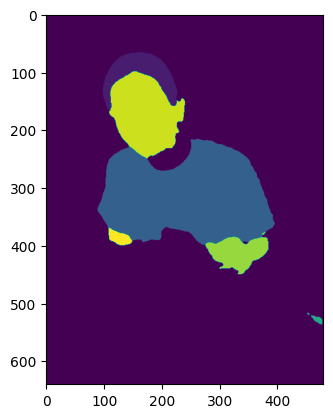

In [104]:
plt.imshow(img)

In [105]:
# dataset_dicts[0].keys()

In [106]:
# dataset_dicts[0]['file_name']

In [75]:
# os.path.basename(dataset_dicts[0]['file_name'])

In [76]:
# register_coco_instances("my_dataset_train", 
#                         {}, 
#                         "/mnt/data1/ayushman/datasets/coco_dataset/annotations/densepose_train2014_cse.json", 
#                         "/mnt/data1/ayushman/datasets/coco_dataset/train2014/")

In [74]:
# metadata = MetadataCatalog.get("my_dataset_train")
# dataset_dicts = DatasetCatalog.get("my_dataset_train")

In [73]:
# for d in random.sample(dataset_dicts, 3):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
#     out = visualizer.draw_dataset_dict(d)
#     plt.imshow(out.get_image())
#     plt.show()

In [77]:
# import shutil

In [79]:
# for d in tqdm(dataset_dicts, dynamic_ncols=True):
#     fp = d['file_name']
#     shutil.copyfile(fp, os.path.join("/mnt/data1/ayushman/datasets/coco_dataset/human",os.path.basename(fp)))

In [80]:
# from PIL import Image

In [81]:
# image = Image.open('/mnt/data1/ayushman/projects/clothes_preprocessor/data/coco_dataset/annotations/human_parsing/COCO_train2014_000000000036.png')

In [82]:
# image

In [83]:
# import numpy as np

In [84]:
# np.unique(np.asanyarray(image))